# HookNet

In [1]:
from hooknet.training.trainer import Trainer
from wholeslidedata.iterators import create_batch_iterator
from wholeslidedata.visualization.plotting import plot_batch

## Data Loading

(5, 284, 284, 3)


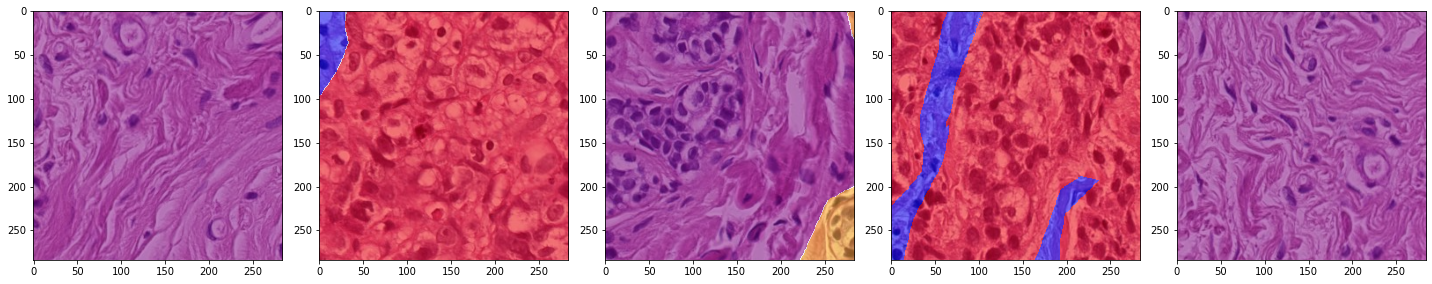

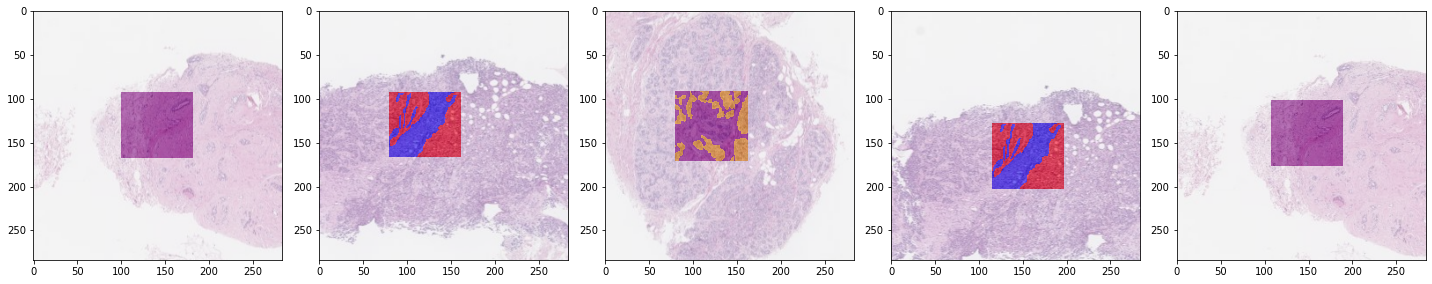

In [12]:
ITERATOR_CONFIG = {
    "wholeslidedata": {
        "default": {
            "seed": 123,
            "yaml_source": "/home/user/pathology-whole-slide-data/docs/source/userguide/notebooks/examples/configs/tigersegmentationdata.yml",
            'labels': {
                "roi": 0,
                "invasive tumor": 1,
                "tumor-associated stroma": 2,
                "in-situ tumor": 3 ,
                "healthy glands": 4,
                "necrosis not in-situ": 5,
                "inflamed stroma": 6,
                "rest": 7,
            },
            "annotation_parser": {
                "sample_label_names": ['roi']
            },
            "batch_shape": {
                "batch_size": 5,
                "shape": [[284,284,3],[284,284,3]],
                "spacing": [0.5, 8.0],
                "y_shape": [2, 284, 284]
            },
            'point_sampler_name': "RandomPointSampler",
            'point_sampler': {
                "buffer": {'spacing': "${batch_shape.spacing}", 'value': -(284//2)},
            },

        }
    }
}

mode = 'training'
number_of_batches = 1
cpus=4

with create_batch_iterator(mode=mode, 
                           user_config=ITERATOR_CONFIG, 
                           number_of_batches=number_of_batches, cpus=4) as training_iterator:
    
    for x_batch, y_batch, info in training_iterator:
        plot_batch(x_batch[:,0,...], y_batch[:,0, ...], alpha=0.5)
        plot_batch(x_batch[:,1,...], y_batch[:,1, ...], alpha=0.5)

## Training

In [3]:
ITERATOR_CONFIG = {
    "wholeslidedata": {
        "default": {
            "seed": 123,
            "yaml_source": "/home/user/pathology-whole-slide-data/docs/source/userguide/notebooks/examples/configs/tigersegmentationdata.yml",
            "labels": {
                "roi": 0,
                "invasive tumor": 1,
                "tumor-associated stroma": 2,
                "in-situ tumor": 3,
                "healthy glands": 4,
                "necrosis not in-situ": 5,
                "inflamed stroma": 6,
                "rest": 7,
            },
            "annotation_parser": {"sample_label_names": ["roi"]},
            "batch_shape": {
                "batch_size": 5,
                "shape": [[284, 284, 3], [284, 284, 3]],
                "spacing": [0.5, 8.0],
                "y_shape": [2, 70, 70, 7],
            },
            "point_sampler_name": "RandomPointSampler",
            "point_sampler": {
                "buffer": {"spacing": "${batch_shape.spacing}", "value": -35},
            },
            "sample_callbacks": [
                {
                    "*object": "wholeslidedata.samplers.callbacks.CropSampleCallback",
                    "output_shape": [70, 70],
                },
                {
                    "*object": "wholeslidedata.samplers.callbacks.OneHotEncodingSampleCallback",
                    "labels": "${dataset.labels}",
                },
            ],
        }
    }
}

HOOKNET_CONFIG = {
    'hooknet': {
        'default': {
            'model': {
                'n_classes': 7,
                'n_filters': 32
            }
        }
    }
}
EPOCHS = 20
STEPS = 100 
CPUS = 4
PROJECT = "HookNet-TIGER" 
LOG_PATH = f"/home/user/{PROJECT}"


In [4]:
trainer = Trainer(iterator_config=ITERATOR_CONFIG, hooknet_config=HOOKNET_CONFIG, epochs=EPOCHS, steps=STEPS, cpus=CPUS, project=PROJECT, log_path=LOG_PATH)

In [ ]:
trainer.train()

wandb: Currently logged in as: mart-vanrijthoven (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


training labels ['invasive tumor', 'roi', 'healthy glands', 'tumor-associated stroma', 'rest']
validation labels ['inflamed stroma', 'invasive tumor', 'roi', 'healthy glands', 'tumor-associated stroma', 'rest']
updated learning rate=2.499999936844688e-05
updated learning rate=1.249999968422344e-05
0 {'training_Loss+L2': 12.346719512939453, 'training_accuracy': 0.535345713943243, 'training_Loss': 1.2586879688501358}
0 {'validation_Loss': 1.7213694873244176}
new best metric:  1.7213694873244176
Saving weights to: /home/user/HookNet-TIGER/hooknet_weights.h5
1 {'training_Loss+L2': 11.673761405944823, 'training_accuracy': 0.5520351028442383, 'training_Loss': 1.124651048183441}
1 {'validation_Loss': 1.760683101116851}
2 {'training_Loss+L2': 10.993405075073243, 'training_accuracy': 0.6131404103338718, 'training_Loss': 0.9264786133170128}
2 {'validation_Loss': 1.7334623463435255}
3 {'training_Loss+L2': 10.558499584197998, 'training_accuracy': 0.594308572858572, 'training_Loss': 0.9182338577508

## Patch Inference